In [1]:
import pandas as pd
import numpy as np
import math 
import torch
import os
import csv
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import pickle 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
root_path = r'/content/gdrive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 2/'
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 2/Dataset A/training-a.csv')
df.drop(df.columns.difference(['filename','digit']),1, inplace=True)
df

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
...,...,...
19697,a19697.png,4
19698,a19698.png,3
19699,a19699.png,8
19700,a19700.png,3


# 1. Dataset

### Load Image Data from Disk

In [4]:
with open(root_path+'img_data_DatasetA', 'rb') as f:
  img_data = pickle.load(f)

### Fetch Data From Image Folder

In [ ]:
img_data = []
resize_dim = (180,180)
img_folder=r'/content/gdrive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 2/Dataset A/training-a'

transformer=transforms.Compose([
    transforms.Resize(resize_dim),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5], [0.5]) # 0-1 to [-1,1] , formula (x-mean)/std
                        
])
for file in os.listdir(img_folder):
    count += 1
    
    # Extracting image file name and class label from csv
    index = int(file[1:6])
    class_label = df['digit'][index]
    
    # open a image using PIL library
    image_path= os.path.join(img_folder, file)
    imgrgb = Image.open(image_path)

    # convert the rgb image into grayscale image
    imgGray = imgrgb.convert('L')

    # transfrom the image into tensor and normalize
    image_tensor = transformer(imgGray)
    img_data.append((image_tensor,class_label))

    if count % 500 == 0:
      print(count, 'images processing completed')

### Display a sample image

Label: 9


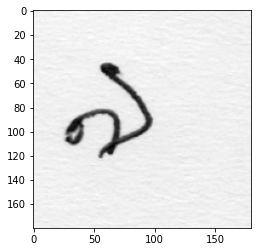

In [5]:
print('Label:',end=' ')
print(img_data[16][1])
show_img = img_data[16][0].numpy().reshape(180, 180)
plt.imshow(show_img, cmap='gray')

### Save Image Data in Disk
it is useful to fetch data faster next time




In [ ]:
with open(root_path+'img_data_DatasetA_resized', 'wb') as f:
  pickle.dump(img_data, f)

### Shape of a image

In [6]:
img_data[0][0].shape

torch.Size([1, 180, 180])

### Spliting dataset into 80-20 ratio

In [7]:
train_data = img_data[:int(len(img_data)*.8)]
test_data = img_data[int(len(img_data)*.8):]

In [8]:
print('Total Number of Samples:',len(img_data))
print('Number of Traning Samples:',len(train_data))
print('Number of Testing Samples:',len(test_data))

Total Number of Samples: 19702
Number of Traning Samples: 15761
Number of Testing Samples: 3941


# 2. Model Creation

## Building Neural Network Model


*   This model has 6 hidden layers
*   ELU activation function is used in each layer
*   CrossEntropyLoss function is used to determine loss
*   Optimizer Used: ASGD (Asynchronous Stochastic Gradient Descent)





In [133]:
#Hidden layers
activation_functions = ['ReLU', 'ReLU', 'ReLU', 'ReLU', 'None', 'None']

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: input_size --> 200
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        # ### 5th hidden layer: 200 --> 200
        # self.linear_5 = nn.Linear(num_hidden, num_hidden)
        # ### Non-linearity in 5th hidden layer
        # self.relu_5 = nn.ELU()

        # ### 6th hidden layer: 200 --> 200
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # ### Non-linearity in 6th hidden layer
        # self.relu_6 = nn.ELU()

        ### Output layer: 200 --> output_size(10)
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        # ### 5th hidden layer
        # out  = self.linear_5(out)
        # ### Non-linearity in 5th hidden layer
        # out = self.relu_5(out)

        # ### 6th hidden layer
        # out  = self.linear_6(out)
        # ### Non-linearity in 6th hidden layer
        # out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

## Setting Hyperparameters


*   Input Size = 180 x 180
*   Output Size = 10 (10 classess of digit 0-9)
*   Batch Size = 20
*   Number of Iterations = 20000
*   Number of nodes in hidden layers = 200
*   Learning Rate = 0.01







In [134]:
batch_size = 20
num_iters = 20000
input_dim = 180*180 # num_features = 32400
num_hidden = 300
output_dim = 10
learning_rate = 0.01
optimizer_name = 'SGD'


model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Testing Model for Dataset A

In [135]:
loss_data,iterations = [],[]

num_epochs = math.ceil(num_iters / (len(train_data) / batch_size))

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

best_accuracy = 0.0
iter = 0
accuracy_data = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter > num_iters:
          break;

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)
                # print(predicted)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            accuracy_data.append(round(accuracy,4))

            ## save the loss and iteration
            loss_data.append(round(loss.item(),4))
            iterations.append(iter)

            #Save the best model
            if accuracy>best_accuracy:
                best_model_state = model.state_dict()
                best_accuracy=accuracy

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, round(loss.item(),4), round(accuracy,4)))

Iteration: 500. Loss: 2.2771. Accuracy: 9.8706
Iteration: 1000. Loss: 2.2445. Accuracy: 10.3527
Iteration: 1500. Loss: 2.3009. Accuracy: 9.9467
Iteration: 2000. Loss: 2.135. Accuracy: 27.7087
Iteration: 2500. Loss: 1.9651. Accuracy: 33.2657
Iteration: 3000. Loss: 2.1326. Accuracy: 33.8493
Iteration: 3500. Loss: 2.1495. Accuracy: 35.8792
Iteration: 4000. Loss: 2.3641. Accuracy: 30.5252
Iteration: 4500. Loss: 1.8331. Accuracy: 40.1675
Iteration: 5000. Loss: 1.5785. Accuracy: 43.0855
Iteration: 5500. Loss: 1.7947. Accuracy: 50.9515
Iteration: 6000. Loss: 2.4246. Accuracy: 33.1895
Iteration: 6500. Loss: 1.7855. Accuracy: 34.3314
Iteration: 7000. Loss: 1.8604. Accuracy: 36.5389
Iteration: 7500. Loss: 2.0427. Accuracy: 43.6691
Iteration: 8000. Loss: 1.4002. Accuracy: 51.2814
Iteration: 8500. Loss: 1.7667. Accuracy: 35.7523
Iteration: 9000. Loss: 1.3795. Accuracy: 58.8683
Iteration: 9500. Loss: 0.9207. Accuracy: 61.4819
Iteration: 10000. Loss: 0.7694. Accuracy: 63.3849
Iteration: 10500. Loss:

### Save the experiment data into csv file

In [136]:
save_data_row = []
save_data_row.append("Dataset A")
save_data_row.append(batch_size)
save_data_row.append(num_hidden)
save_data_row.append(num_iters)
save_data_row.extend(activation_functions)
save_data_row.append(optimizer_name)
save_data_row.extend(accuracy_data)
save_data_row.append(round(loss.item(),4))
with open(root_path+'Experiment 2 Results_03.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(save_data_row)
    print('Data updated into file')

Data updated into file


### Experimental Summary

In [137]:
df_summary = pd.read_csv(root_path+'Experiment 2 Results_03.csv')
df_summary

,Dataset,Batch size,Nodes,Iterations,1st HL,2nd HL,3rd HL,4th HL,5th HL,6th HL,Optimizer,Acc(500),Acc(1000),Acc(1500),Acc(2000),Acc(2500),Acc(3000),Acc(3500 ),Acc(4000),Acc(4500),Acc(5000),Acc(5500),Acc(6000),Acc(6500),Acc(7000),Acc(7500),Acc(8000),Acc(8500),Acc(9000),Acc(9500),Acc(10000),Acc(10500),Acc(11000),Acc(11500),Acc(12000),Acc(12500),Acc(13000),Acc(13500),Acc(14000),Acc(14500),Acc(15000),Acc(15500),Acc(16000),Acc(16500),Acc(17000),Acc(17500),Acc(18000),Acc(18500),Acc(19000),Acc(19500),Acc(20000),Loss
0,Dataset A,10,200,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,9.5915,9.6422,9.9213,9.6676,13.9812,19.4367,16.3918,17.5844,23.7757,31.1342,31.2104,25.5011,34.0523,23.8011,21.8219,36.2091,41.2332,40.5988,36.3867,27.6833,31.0581,46.0036,48.8201,55.7219,50.7993,50.0127,49.6067,32.9612,41.3854,58.0310,37.5539,57.2951,36.4375,52.5247,61.3042,53.5143,43.4154,67.0642,45.0647,62.5222,0.7933
1,Dataset A,10,100,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3273,15.5291,12.9155,9.8960,11.6214,13.5499,23.0906,28.0639,20.7815,14.9454,12.4588,29.4088,37.7823,38.5435,28.9520,24.7399,36.4121,36.1076,38.1375,35.2956,43.9229,54.6562,49.6574,38.8480,57.8026,45.4453,41.8422,48.3380,41.5884,34.1791,53.9964,45.1408,30.1446,59.6549,57.7772,61.3804,45.4707,64.7805,61.5580,52.8292,1.2075
2,Dataset A,10,300,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3273,9.5154,9.7945,16.2649,10.9363,14.2857,9.6676,29.1550,30.1700,25.3743,28.2669,19.5889,33.6463,30.8044,29.8655,40.4720,19.5382,30.9820,38.4166,50.5963,43.8721,56.2548,42.4512,47.6275,53.0576,43.0855,52.5501,57.8787,48.6425,41.5884,42.3497,65.4402,57.1936,53.3367,67.6732,62.6237,49.0992,66.0492,67.0134,57.6503,0.8252
3,Dataset A,10,400,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3527,10.5303,9.6676,15.9604,15.1738,9.8960,11.8752,18.7516,37.2748,33.4687,26.8206,23.0398,30.0939,23.6488,48.0589,22.5831,32.0731,27.4550,29.0282,47.7036,45.8259,59.4773,51.4590,58.0817,62.3700,59.2997,57.5996,52.3725,34.3314,52.1441,66.5060,59.5788,59.6803,19.5889,50.1396,64.6029,40.7765,63.2327,28.2923,61.5834,0.7911
4,Dataset A,10,500,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3273,10.3273,10.5303,9.6930,9.8706,17.3560,19.5382,19.7412,25.1967,28.2669,26.2877,24.1309,27.9624,37.5793,24.6892,46.9170,44.3035,37.5793,37.4270,27.9371,30.7282,39.2032,42.4512,27.3281,58.1325,49.1753,47.4499,53.0576,49.5052,66.5313,53.2606,54.8592,49.4037,66.1253,71.5808,51.8396,44.1512,44.8110,59.7564,70.3629,0.5334
5,Dataset 2,10,500,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,30.6600,50.3700,49.8000,72.5100,71.4100,76.0500,76.5900,79.5000,81.6100,80.2100,82.6500,81.9200,83.8200,83.9400,83.7000,82.1800,84.5700,85.1900,82.6800,83.5500,85.1900,83.9800,84.9200,85.4500,85.0500,86.1000,85.0100,84.0000,85.7800,86.6300,85.3700,86.2100,85.6700,86.7000,86.1500,85.8900,0.4419,NaN,NaN,NaN,NaN
6,Dataset 2,10,400,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,23.7000,47.2700,63.1200,64.6600,74.0300,75.8900,76.4200,79.7000,79.6000,82.0200,81.9500,79.7500,82.8000,84.4100,81.9900,81.7200,84.2200,82.4700,83.5800,84.4600,84.4500,85.1300,84.9000,85.2600,85.7600,86.3100,85.9900,83.5200,85.1900,86.1900,86.1300,85.8200,85.9300,86.8300,85.0300,86.5300,0.3588,NaN,NaN,NaN,NaN
7,Dataset 2,10,300,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,34.7300,42.6000,65.7800,69.2700,73.6200,75.8200,76.3500,76.7500,78.0400,75.6800,79.2400,79.5300,80.0500,80.7600,81.9100,83.3700,81.4800,79.7500,84.7100,83.2700,84.0400,84.9800,84.1000,84.1300,84.5400,84.5900,81.5100,85.3500,84.9500,85.5200,85.9300,85.9500,85.1200,85.7200,86.2600,84.6900,0.9195,NaN,NaN,NaN,NaN
8,Dataset 2,10,100,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,18.6800,20.6200,43.4500,60.0000,65.2600,70.6400,74.8500,75.6800,76.4000,77.1500,78.2300,80.1100,78.2600,81.3000,81.5700,82.4000,83.1100,83.0000,82.8900,82.0500,83.2200,84.3600,84.5800,82.4700,84.6800,84.6600,84.6600,85.6000,85.3900,83.4500,82.3000,84.8900,86.3100,85.6000,85.8900,85.4000,0.1826,NaN,NaN,NaN,NaN
9,Dataset 2,10,200,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,38.5200,31.9800,59.4900,66.8400,68.7900,73.3100,75.5600,77

## Making Prediction

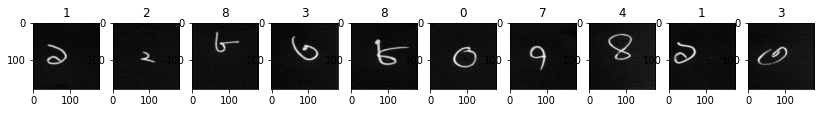

,Actual Value,Predicted Value
1,1,1
2,2,2
3,8,9
4,3,3
5,8,8
6,0,0
7,7,7
8,4,4
9,1,8
10,3,3


In [145]:
num_predictions = 10

for images, labels in test_loader:
    break
    
plt.figure(figsize=(14,14))
for i in range(num_predictions):
    ax=plt.subplot(1,num_predictions,i+1)
    ax.title.set_text(labels[i].item())
    plt.imshow(images[i].view(180, 180), cmap=plt.cm.binary)

plt.show()

# loading the best model of current run
model.load_state_dict(best_model_state)

predictions = model.forward(images[0:num_predictions].view(-1, 180*180).to(device))
predictions = torch.argmax(predictions, dim=1)

df_prediction = pd.DataFrame(list(zip(labels[0:num_predictions].cpu().numpy(), predictions.cpu().numpy())),
               columns =['Actual Value', 'Predicted Value'],index=[i for i in range(1,num_predictions+1)])
df_prediction

### Save the Best Model

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(best_model_state, root_path + 'Assignment 2_Dataset A_exp02_2_ReLUELU_SGD.pkl')

### Load the Best Model

In [ ]:
load_model = True
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Assignment 2_Dataset A_exp02_2_SELU_SGD.pkl'))

## Loss vs Iteration Curve

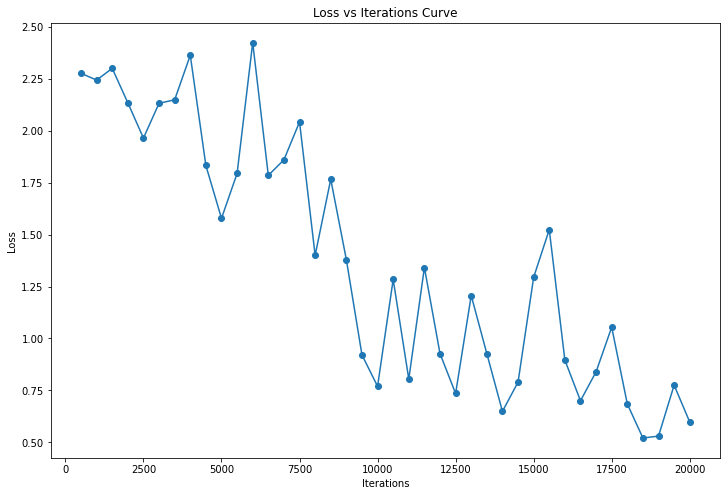

In [144]:
plt.figure(figsize=(12,8))
plt.plot(iterations,loss_data,marker='o')
plt.title('Loss vs Iterations Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# plt.savefig(root_path+'Loss vs iteration_Dataset A_ReLUELU_SGD.jpg')
plt.show()

# 3. Checking my Models’ Performance by Another Dataset

## 1. Dataset

### Reading the csv dataset and making some necessary adjustment

In [39]:
df_2_train = pd.read_csv('/content/gdrive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 2/Dataset_2/verification_train.csv')
df_2_test = pd.read_csv('/content/gdrive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 2/Dataset_2/verification_test.csv')

# storing the label in different variable
train_classfication_labels = np.array(df_2_train['label'])
test_classfication_labels = np.array(df_2_test['label'])

df_2_train.drop(['label'],axis=1,inplace=True)
df_2_test.drop(['label'],axis=1,inplace=True)

# converting the image pixel into numpy of datatype unsigned 8 bit
train_img_data_np = np.array(df_2_train, dtype=np.uint8)
test_img_data_np = np.array(df_2_test, dtype=np.uint8)

### Normalizing the dataset and converting into tensor

In [40]:
train_img_data_2 = []
test_img_data_2 = []

transformer=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5],[0.5]) # 0-1 to [-1,1] , formula (x-mean)/std                   
])

# for training data
for index, data in enumerate(train_img_data_np,start=0):
  img = data.reshape(28,28)
  image_tensor = transformer(img)
  train_img_data_2.append((image_tensor,train_classfication_labels[index]))

# for testing data
for index,data in enumerate(test_img_data_np,start=0):
  img = data.reshape(28,28)
  image_tensor = transformer(img)
  test_img_data_2.append((image_tensor,test_classfication_labels[index]))


print('Number of training sample:',len(train_img_data_2))
print('Number of testing sample:',len(test_img_data_2))

Number of training sample: 60000
Number of testing sample: 10000


### Display a sample image

Label: 0


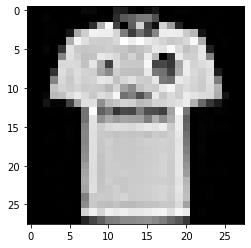

In [41]:
print('Label:',end=' ')
print(test_img_data_2[0][1])
show_img = test_img_data_2[0][0].reshape(28, 28)
plt.imshow(show_img, cmap='gray')

## Testing Model For Dataset 2

### Setting Hyperparameters


*   Input Size = 28 x 28
*   Output Size = 10 (10 classes of 0-9)
*   Batch Size = 20
*   Number of Iterations = 20000
*   Number of nodes in hidden layers = 200
*   Learning Rate = 0.01

In [138]:
batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 300
output_dim = 10
learning_rate = 0.01


model2 = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# To enable GPU
model2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)

In [139]:
loss_data2,iterations2 = [],[]

num_epochs = round(num_iters / (len(train_img_data_2) / batch_size))
# num_epochs = int(num_epochs)

train_loader2 = torch.utils.data.DataLoader(dataset=train_img_data_2, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader2 = torch.utils.data.DataLoader(dataset=test_img_data_2, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


best_accuracy = 0.0
iter = 0
accuracy_data2 = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader2):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model2(images) 


        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter > 20000:
          break;

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader2:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model2(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)
                # print(predicted)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            accuracy_data2.append(round(accuracy,4))

            ## save the loss and iteration
            loss_data2.append(round(loss.item(),4))
            iterations2.append(iter)

            #Save the best model
            if accuracy>best_accuracy:
                # torch.save(model.state_dict(),root_path+'test_assignment 2_Dataset A_FNN.pkl')
                best_model2_state = model2.state_dict()
                best_accuracy=accuracy

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.4751936197280884. Accuracy: 43.5
Iteration: 1000. Loss: 0.6199662089347839. Accuracy: 68.48
Iteration: 1500. Loss: 0.8312870860099792. Accuracy: 73.65
Iteration: 2000. Loss: 0.9985982775688171. Accuracy: 72.14
Iteration: 2500. Loss: 0.38841512799263. Accuracy: 79.38
Iteration: 3000. Loss: 0.5823694467544556. Accuracy: 80.15
Iteration: 3500. Loss: 0.23676002025604248. Accuracy: 80.16
Iteration: 4000. Loss: 0.7984260320663452. Accuracy: 82.6
Iteration: 4500. Loss: 0.45225605368614197. Accuracy: 81.77
Iteration: 5000. Loss: 0.8112614750862122. Accuracy: 81.72
Iteration: 5500. Loss: 0.4176124632358551. Accuracy: 83.31
Iteration: 6000. Loss: 0.5212787389755249. Accuracy: 83.91
Iteration: 6500. Loss: 0.6060039401054382. Accuracy: 84.13
Iteration: 7000. Loss: 0.5551949143409729. Accuracy: 84.27
Iteration: 7500. Loss: 0.44146060943603516. Accuracy: 85.06
Iteration: 8000. Loss: 0.2854391932487488. Accuracy: 84.71
Iteration: 8500. Loss: 0.24564078450202942. Accuracy: 85.3

### Save the experiment data into csv file

In [140]:
save_data_row = []
save_data_row.append("Dataset 2")
save_data_row.append(batch_size)
save_data_row.append(num_hidden)
save_data_row.append(num_iters)
save_data_row.extend(activation_functions)
save_data_row.append(optimizer_name)
save_data_row.extend(accuracy_data2)
save_data_row.append(round(loss.item(),4))
with open(root_path+'Experiment 2 Results_03.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(save_data_row)
    print('Data updated into file')

Data updated into file


### Experimental Summary

In [141]:
df_summary = pd.read_csv(root_path+'Experiment 2 Results_03.csv')
df_summary

,Dataset,Batch size,Nodes,Iterations,1st HL,2nd HL,3rd HL,4th HL,5th HL,6th HL,Optimizer,Acc(500),Acc(1000),Acc(1500),Acc(2000),Acc(2500),Acc(3000),Acc(3500 ),Acc(4000),Acc(4500),Acc(5000),Acc(5500),Acc(6000),Acc(6500),Acc(7000),Acc(7500),Acc(8000),Acc(8500),Acc(9000),Acc(9500),Acc(10000),Acc(10500),Acc(11000),Acc(11500),Acc(12000),Acc(12500),Acc(13000),Acc(13500),Acc(14000),Acc(14500),Acc(15000),Acc(15500),Acc(16000),Acc(16500),Acc(17000),Acc(17500),Acc(18000),Acc(18500),Acc(19000),Acc(19500),Acc(20000),Loss
0,Dataset A,10,200,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,9.5915,9.6422,9.9213,9.6676,13.9812,19.4367,16.3918,17.5844,23.7757,31.1342,31.2104,25.5011,34.0523,23.8011,21.8219,36.2091,41.2332,40.5988,36.3867,27.6833,31.0581,46.0036,48.8201,55.7219,50.7993,50.0127,49.6067,32.9612,41.3854,58.0310,37.5539,57.2951,36.4375,52.5247,61.3042,53.5143,43.4154,67.0642,45.0647,62.5222,0.7933
1,Dataset A,10,100,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3273,15.5291,12.9155,9.8960,11.6214,13.5499,23.0906,28.0639,20.7815,14.9454,12.4588,29.4088,37.7823,38.5435,28.9520,24.7399,36.4121,36.1076,38.1375,35.2956,43.9229,54.6562,49.6574,38.8480,57.8026,45.4453,41.8422,48.3380,41.5884,34.1791,53.9964,45.1408,30.1446,59.6549,57.7772,61.3804,45.4707,64.7805,61.5580,52.8292,1.2075
2,Dataset A,10,300,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3273,9.5154,9.7945,16.2649,10.9363,14.2857,9.6676,29.1550,30.1700,25.3743,28.2669,19.5889,33.6463,30.8044,29.8655,40.4720,19.5382,30.9820,38.4166,50.5963,43.8721,56.2548,42.4512,47.6275,53.0576,43.0855,52.5501,57.8787,48.6425,41.5884,42.3497,65.4402,57.1936,53.3367,67.6732,62.6237,49.0992,66.0492,67.0134,57.6503,0.8252
3,Dataset A,10,400,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3527,10.5303,9.6676,15.9604,15.1738,9.8960,11.8752,18.7516,37.2748,33.4687,26.8206,23.0398,30.0939,23.6488,48.0589,22.5831,32.0731,27.4550,29.0282,47.7036,45.8259,59.4773,51.4590,58.0817,62.3700,59.2997,57.5996,52.3725,34.3314,52.1441,66.5060,59.5788,59.6803,19.5889,50.1396,64.6029,40.7765,63.2327,28.2923,61.5834,0.7911
4,Dataset A,10,500,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,10.3273,10.3273,10.5303,9.6930,9.8706,17.3560,19.5382,19.7412,25.1967,28.2669,26.2877,24.1309,27.9624,37.5793,24.6892,46.9170,44.3035,37.5793,37.4270,27.9371,30.7282,39.2032,42.4512,27.3281,58.1325,49.1753,47.4499,53.0576,49.5052,66.5313,53.2606,54.8592,49.4037,66.1253,71.5808,51.8396,44.1512,44.8110,59.7564,70.3629,0.5334
5,Dataset 2,10,500,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,30.6600,50.3700,49.8000,72.5100,71.4100,76.0500,76.5900,79.5000,81.6100,80.2100,82.6500,81.9200,83.8200,83.9400,83.7000,82.1800,84.5700,85.1900,82.6800,83.5500,85.1900,83.9800,84.9200,85.4500,85.0500,86.1000,85.0100,84.0000,85.7800,86.6300,85.3700,86.2100,85.6700,86.7000,86.1500,85.8900,0.4419,NaN,NaN,NaN,NaN
6,Dataset 2,10,400,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,23.7000,47.2700,63.1200,64.6600,74.0300,75.8900,76.4200,79.7000,79.6000,82.0200,81.9500,79.7500,82.8000,84.4100,81.9900,81.7200,84.2200,82.4700,83.5800,84.4600,84.4500,85.1300,84.9000,85.2600,85.7600,86.3100,85.9900,83.5200,85.1900,86.1900,86.1300,85.8200,85.9300,86.8300,85.0300,86.5300,0.3588,NaN,NaN,NaN,NaN
7,Dataset 2,10,300,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,34.7300,42.6000,65.7800,69.2700,73.6200,75.8200,76.3500,76.7500,78.0400,75.6800,79.2400,79.5300,80.0500,80.7600,81.9100,83.3700,81.4800,79.7500,84.7100,83.2700,84.0400,84.9800,84.1000,84.1300,84.5400,84.5900,81.5100,85.3500,84.9500,85.5200,85.9300,85.9500,85.1200,85.7200,86.2600,84.6900,0.9195,NaN,NaN,NaN,NaN
8,Dataset 2,10,100,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,18.6800,20.6200,43.4500,60.0000,65.2600,70.6400,74.8500,75.6800,76.4000,77.1500,78.2300,80.1100,78.2600,81.3000,81.5700,82.4000,83.1100,83.0000,82.8900,82.0500,83.2200,84.3600,84.5800,82.4700,84.6800,84.6600,84.6600,85.6000,85.3900,83.4500,82.3000,84.8900,86.3100,85.6000,85.8900,85.4000,0.1826,NaN,NaN,NaN,NaN
9,Dataset 2,10,200,20000,ReLU,ELU,ReLU,ELU,ReLU,ELU,SGD,38.5200,31.9800,59.4900,66.8400,68.7900,73.3100,75.5600,77

## Making Prediction

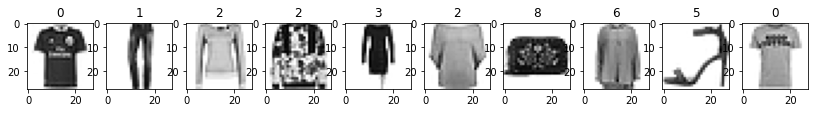

,Actual Value,Predicted Value
1,0,6
2,1,1
3,2,2
4,2,2
5,3,4
6,2,6
7,8,8
8,6,6
9,5,5
10,0,0


In [142]:
num_predictions = 10

for images, labels in test_loader2:
    break
    

plt.figure(figsize=(14,14))
for i in range(num_predictions):
    ax=plt.subplot(1,num_predictions,i+1)
    ax.title.set_text(labels[i].item())
    plt.imshow(images[i].view(28, 28), cmap=plt.cm.binary)

plt.show()

# loading the best model of current run
model2.load_state_dict(best_model2_state)

predictions = model2.forward(images[0:num_predictions].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)

df_prediction_2 = pd.DataFrame(list(zip(labels[0:num_predictions].cpu().numpy(), predictions.cpu().numpy())),
               columns =['Actual Value', 'Predicted Value'],index=[i for i in range(1,num_predictions+1)])
df_prediction_2

### Save the Best Model

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(best_model2_state, root_path + 'Assignment 2_Dataset 2_exp02_2_ReLUELU_SGD.pkl')

### Load the Best Model

In [ ]:
load_model = True
if load_model is True:
    model2.load_state_dict(torch.load(root_path + 'Assignment 2_Dataset 2_exp02_2.pkl'))

## Loss vs Interation Plot for Dataset 2

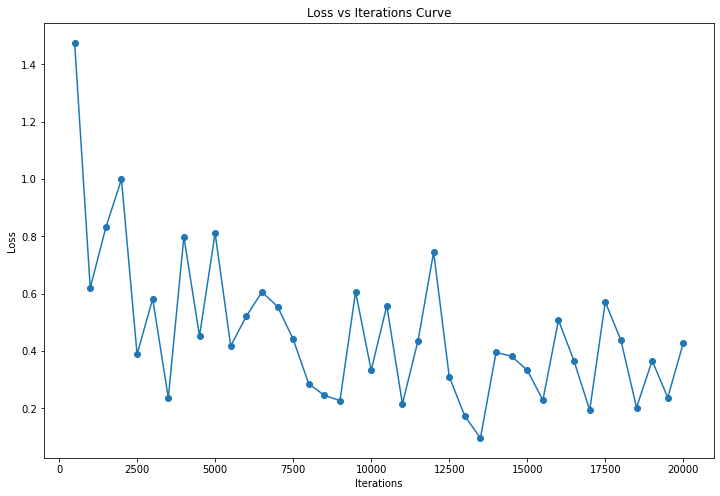

In [143]:
plt.figure(figsize=(12,8))
plt.plot(iterations2,loss_data2,marker='o')
plt.title('Loss vs Iterations Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# plt.savefig(root_path+'Loss vs iteration_Dataset 2_ReLUELU_SGD.jpg')
plt.show()